<a href="https://colab.research.google.com/github/jesusmiguel123/PC-5/blob/main/Text_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

En el presente cuaderno se utilizará la arquitectura de los transformers introducida en el paper 'Atention is All you need', se enfocará en implementar múltiples métododes de decodificación (decoders) además de evaluar y comparar la calidad del texto que producen.

Se utilizará un modelador de lenguaje en español
https://huggingface.co/datificate/gpt2-small-spanish
 basado del conocido generador de texto GPT-2, en adición se utilizará una API de transformers realizada por Hugging Face. https://github.com/huggingface/transformers

#Inicio
Instalamos la librería de transformers


In [4]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 645kB 6.6MB/s 
     |████████████████████████████████| 901kB 34.0MB/s 
     |████████████████████████████████| 3.3MB 29.9MB/s 


Realizamos los imports correspondientes para utilizar el tokenizer y el modelo de gpt2-small-spanish

In [5]:

import torch

from transformers import AutoTokenizer, AutoModelWithLMHead
  
tokenizer = AutoTokenizer.from_pretrained("datificate/gpt2-small-spanish")
model = AutoModelWithLMHead.from_pretrained("datificate/gpt2-small-spanish")
torch.manual_seed(1)

/usr/local/lib/python3.7/dist-packages/transformers/models/auto/modeling_auto.py:902: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  FutureWarning,


#Decoders

## Búsqueda Greedy

In [22]:
#Especificamos el mensaje base, y el tipo de retorno del tokenizer como pt(pytorch)

message = "El ave volo sobre el monte hacia el horizonte"
input = tokenizer(message , return_tensors='pt')
print(input)

{'input_ids': tensor([[  491, 11512,  1017,    79,   623,   284,  8225,  1155,   284, 22336]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}


En el paso anterior se pasa el tokenizer al mensaje, esto nos devuelve un dictionary, con un id que corresponde a una palabra, y una máscara de atención(en este caso esta llena de 1 debido a que todos los valores deben ser tomados)

Lo siguiente es pasar al model el mesange tokenizado para que genere nuevo texto, en el caso del enfoque greedy en cada paso se escoge la siguiente palabra con más probabilidad de ser escogida.

En la imagen cuando la última palabra es THE entonces tenemos 3 opciones:


1.  Dog: con 0.4%
2.  Nice: con 0.5%
3.  Car: con 0.1%

En este caso se escogerá la palabra Nice debido a que tiene mayor probabilidad, al siguiente paso sucede algo similar, entonces se escoge la palabra woman debido a que tiene mayor probabilidad que las otras.

Entonces la frase resultante es: The nice woman




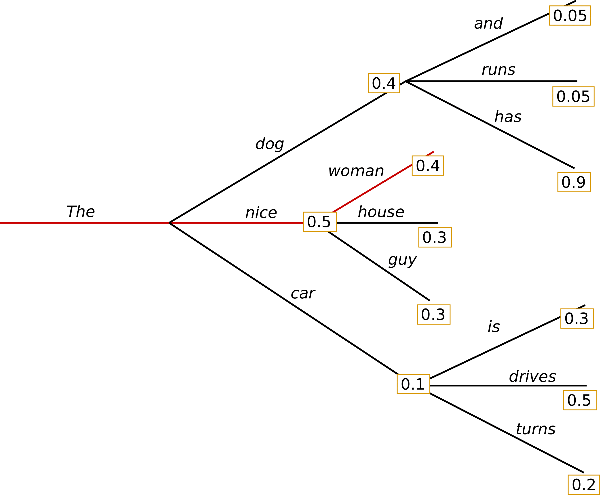

In [23]:
from IPython.display import Image
Image('greedy_search.png')


Generamos el texto y especificamos la longitud del tensor resultante

In [18]:
text = model.generate(**input, max_length=150)
print(text)
print(type(text))
print(text.shape)

tensor([[  491, 11512,  1017,    79,   623,   284,  8225,  1155,   284, 22336,
            14,   199,   199,   491,  5099,   258,   276, 30750,   293,   298,
          2336,   258,   276,  3296,    12,   301,   306, 17359,   278,   284,
          3608,    12,   287,   301,   306, 17359,   278,   284,  3608,    14,
           486, 30750,   306, 17359,   278,   284,  3608,    12,   287,   306,
         17359,   278,   284,  3608,    14,   486, 30750,   306, 17359,   278,
           284,  3608,    12,   287,   306, 17359,   278,   284,  3608,    14,
           486, 30750,   306, 17359,   278,   284,  3608,    12,   287,   306,
         17359,   278,   284,  3608,    14,   486, 30750,   306, 17359,   278,
           284,  3608,    12,   287,   306, 17359,   278,   284,  3608,    14,
           486, 30750,   306, 17359,   278,   284,  3608,    12,   287,   306,
         17359,   278,   284,  3608,    14,   486, 30750,   306, 17359,   278,
           284,  3608,    12,   287,   306, 17359,  

El método tokenizer.decode transforma un tensor de ids al vocabulario (texto entendible para las personas), como parámetros opcional especificamos obviar caracteres especiales como classifiers o separators.

In [17]:
print(tokenizer.decode(text[0], skip_special_tokens=True))

El ave volo sobre el monte hacia el horizonte.

El vuelo de la paloma es un movimiento de la cabeza, que se mueve en el aire, y que se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en el aire, y se mueve en el aire. La paloma se mueve en


Conclusión:

#Beam search


En este método se escogerá mútiples secuencias, siempre tratando de buscar las secuencias con mayor probabilidad y manteniendo el mismo número de secuencias.

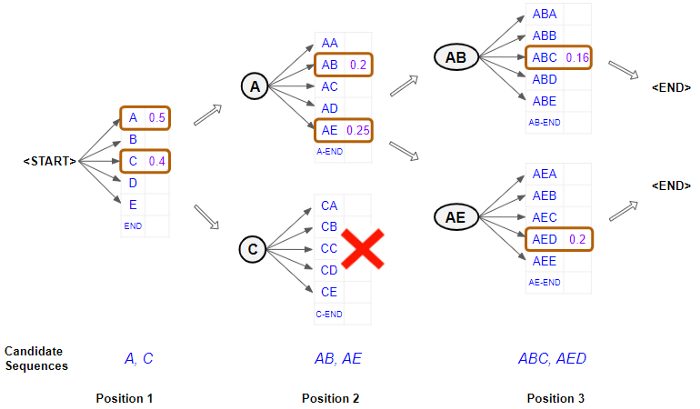

In [25]:
from IPython.display import Image
Image('Beam_search.png')

En este ejemplo empezamos con las 2 probabilidades más altas(A y C).

Luego en el siguiente paso tenemos 10 nuevas alternativas (5 de seguir A y 5 de seguir C), en este caso las que maximixan son las secuencias de A (AB, AE) asi que seguimos esas secuencias.

Finalmente se repite el mismo procedimiento dando como resultado dos secuencias ( ABC, AED).


In [28]:
#Especificamos algunos parámetros antes de realizar la búsqueda beam
n_beams = 5 #Número de secuencias que se van a seguir
ngram_no_repeat = 3  #La longitud de los n-gramas que no se pueden repetir


Generamos n_beams salidas utilizando la busqueda beam.

In [29]:
beam = model.generate(
    **input,
    max_length=150,
    num_beams= n_beams,
    early_stopping=True,
    no_repeat_ngram_size= ngram_no_repeat,
    num_return_sequences= n_beams,
)


Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:575: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  /pytorch/aten/src/ATen/native/BinaryOps.cpp:467.)
  return torch.floor_divide(self, other)


In [34]:
#imprimimos los resultados obtenidos
for i, output in enumerate(beam):
  print(f'{i}: {tokenizer.decode(output, skip_special_tokens=True)}')
  print("", end='\n\n')

0: El ave volo sobre el monte hacia el horizonte.

En la mitología griega, el ave volaba sobre el Monte Olimpo, en el monte Olimpo. En la mitología romana, el águila volaba en el cielo, y en la mitología egipcia, el halcón volaba alrededor del Monte Olimpo. 

En el folclore griego, el pájaro volaba a lo largo de la costa del mar Mediterráneo. En el folclore egipcio, el vuelo de un pájaro volador sobre el mar Mediterráneo era una forma de volar sobre la tierra. En los mitos griegos, el avión volador era un ave voladora que volaba hacia el cielo. En las religiones animistas, el volador volador es un animal volador que vuela sobre la Tierra.



1: El ave volo sobre el monte hacia el horizonte.

En la mitología griega, el ave volaba sobre el Monte Olimpo, en el monte Olimpo. En la mitología romana, el águila volaba en el cielo, y en la mitología egipcia, el halcón volaba alrededor del Monte Olimpo. 

En el folclore griego, el pájaro volaba a lo largo de la costa del mar Mediterráneo. En el